In [0]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

In [0]:
train_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_train.csv',
                              parse_dates=[3])

test_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv',
                             parse_dates=[3])
df = pd.concat([train_features, test_features], axis = 0)

In [0]:
df_sj = df[df['city'] == 'sj']
df_iq = df[df['city'] == 'iq']

Impute missing values using forward filling

In [0]:
df_sj = df_sj.fillna(method = 'ffill')
df_iq = df_iq.fillna(method = 'ffill')

In [0]:
df_sj.set_index('week_start_date', drop = True, inplace = True)
df_iq.set_index('week_start_date', drop = True, inplace = True)
#df_sj

In [0]:
df_sj.drop(['city', 'year'], axis = 1, inplace = True)
df_iq.drop(['city', 'year'], axis = 1, inplace = True)
#df_sj

In [7]:
train_labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv')
train_labels_sj = train_labels[train_labels['city'] == 'sj']['total_cases']
print train_labels_sj
train_labels_iq = train_labels[train_labels['city'] == 'iq']['total_cases']

0        4
1        5
2        4
3        3
4        6
5        2
6        4
7        5
8       10
9        6
10       8
11       2
12       6
13      17
14      23
15      13
16      21
17      28
18      24
19      20
20      40
21      27
22      42
23      33
24      43
25      37
26      57
27      71
28      44
29      56
      ... 
906    170
907    135
908    106
909     68
910     48
911     48
912     26
913     33
914     29
915     17
916     12
917     13
918     17
919     15
920     14
921     15
922     10
923      9
924      2
925      6
926      8
927      5
928      1
929      2
930      3
931      4
932      3
933      1
934      3
935      5
Name: total_cases, Length: 936, dtype: int64


create month variable

In [0]:
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

#SJ

get monthly trend

In [9]:
x_train_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
x_test_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = train_labels_sj.values

# Split data hold out validation
xx_train_months = x_train_months[:717]
xx_valid_months = x_train_months[717:]
yy_train = y[:717]
yy_valid = y[717:]

# Check split lengths
print len(x_train_months), len(xx_train_months), len(xx_valid_months)
print len(y), len(yy_train), len(yy_valid)

936 717 219
936 717 219


In [0]:
# Get values for hold out validation
sj_month_lr_holdout = LinearRegression()
sj_month_lr_holdout.fit(xx_train_months, yy_train)
monthly_trend_holdout = pd.Series(sj_month_lr_holdout.predict(xx_train_months)).rolling(window=3, min_periods=1).mean()
sj_residuals_all_holdout = yy_train - monthly_trend_holdout

# Get values for entire training set
sj_month_lr = LinearRegression()
sj_month_lr.fit(x_train_months, y)
monthly_trend = pd.Series(sj_month_lr.predict(x_train_months)).rolling(window=3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend

Correlation of features with total cases and residuals

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


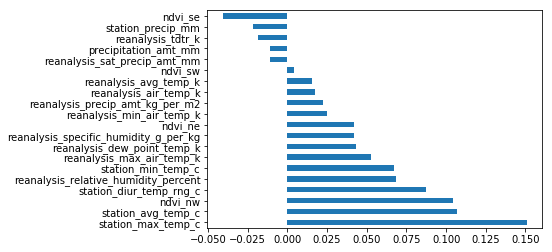

In [11]:
# compute the correlations
sj_features_with_lables = train_features[train_features['city'] == 'sj']
sj_features_with_lables['total_cases'] = train_labels_sj
sj_features_with_lables['residuals'] = sj_residuals_all
sj_correlations = sj_features_with_lables.corr()

(sj_correlations
     .residuals
     .drop('total_cases')
     .drop('year')
     .drop('weekofyear') 
     .drop('residuals') 
     .sort_values(ascending=False)
     .plot
     .barh())

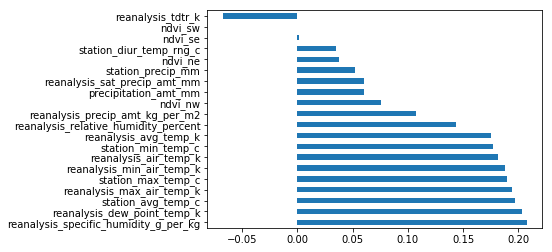

In [12]:

(sj_correlations
     .total_cases
     .drop('total_cases')
     .drop('year')
     .drop('weekofyear') 
     .drop('residuals') 
     .sort_values(ascending=False)
     .plot
     .barh())

rolling means df

In [0]:
x_train_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:936]
x_train_means2 = df_sj['reanalysis_relative_humidity_percent'].rolling(window = 52).mean()[60:936]
x_train_means3 = df_sj['reanalysis_precip_amt_kg_per_m2'].rolling(window = 52).mean()[60:936]

combine all dfs

In [0]:
x_train = pd.concat([x_train_means1,x_train_means2,x_train_means3], axis = 1)
y_train = sj_residuals_all[60:]

# For holdout validation
xx_train = pd.concat([x_train_means1[:657],x_train_means2[:657],x_train_means3[:657]], axis = 1)
yy_train = sj_residuals_all_holdout[60:]
xx_valid = pd.concat([x_train_means1[657:],x_train_means2[657:],x_train_means3[657:]], axis = 1)

In [0]:
x_test_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[936:]
x_test_means2 = df_sj['reanalysis_relative_humidity_percent'].rolling(window = 52).mean()[936:]
x_test_means3 = df_sj['reanalysis_precip_amt_kg_per_m2'].rolling(window = 52).mean()[936:]

In [0]:
x_test = pd.concat([x_test_means1,x_test_means2,x_test_means3], axis = 1)

In [17]:
sj_residual_lr = linear_model.Lasso()
sj_residual_lr.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

 make predictions on monthly data and residual data

In [0]:
sj_monthly_prediction = pd.Series(sj_month_lr.predict(x_test_months)).rolling(3, min_periods=1).mean()
sj_resid_prediction = sj_residual_lr.predict(x_test)
sj_cases_predictions = pd.Series(sj_resid_prediction + sj_monthly_prediction).rolling(1, min_periods=1).mean()
sj_cases_predictions = sj_cases_predictions.apply(lambda x: 1 if x < 1 else int(x))

Holdout validation

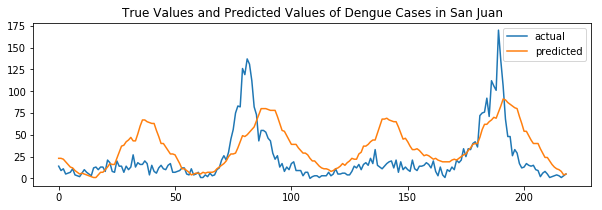

21.885844748858446


In [19]:
sj_residual_lr_holdout = linear_model.Lasso()
sj_residual_lr_holdout.fit(xx_train, yy_train)

sj_monthly_prediction_holdout = pd.Series(sj_month_lr_holdout.predict(xx_valid_months)).rolling(3, min_periods=1).mean()
sj_resid_prediction_holdout = sj_residual_lr_holdout.predict(xx_valid)
sj_cases_predictions_holdout = pd.Series(sj_resid_prediction_holdout + sj_monthly_prediction_holdout).rolling(1, min_periods=1).mean()
sj_cases_predictions_holdout = sj_cases_predictions_holdout.apply(lambda x: 1 if x < 1 else int(x))

# Plot
plt.figure(figsize=(10, 3))
plt.title('True Values and Predicted Values of Dengue Cases in San Juan')
plt.plot(yy_valid, label = 'actual')
plt.plot(sj_cases_predictions_holdout, label = 'predicted')
plt.legend()
plt.show()

print mean_absolute_error(sj_cases_predictions_holdout, yy_valid)

Plot Monthly trend, Residuals, and True values.

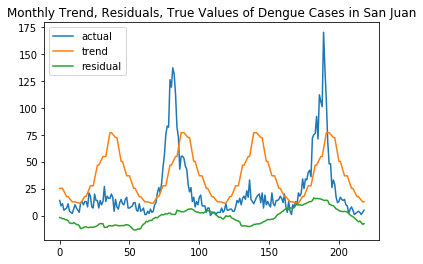

In [20]:
# Plot
plt.title('Monthly Trend, Residuals, True Values of Dengue Cases in San Juan')
plt.plot(yy_valid, label = 'actual')
plt.plot(sj_monthly_prediction_holdout, label = 'trend')
plt.plot(sj_resid_prediction_holdout, label = 'residual')
plt.legend()
plt.show()

# IQ

In [21]:
x_train_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
x_test_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = train_labels_iq.values

# Split data hold out validation
xx_train_months = x_train_months[:398]
xx_valid_months = x_train_months[398:]
yy_train = y[:398]
yy_valid = y[398:]

# Check split lengths
print len(x_train_months), len(xx_train_months), len(xx_valid_months)
print len(y), len(yy_train), len(yy_valid)

520 398 122
520 398 122


In [22]:
# Get values for hold out validation
iq_month_lr_holdout = LinearRegression()
iq_month_lr_holdout.fit(xx_train_months, yy_train)
monthly_trend_holdout = pd.Series(iq_month_lr_holdout.predict(xx_train_months)).rolling(window=3, min_periods=1).mean()
iq_residuals_all_holdout = yy_train - monthly_trend_holdout

# Get values for entire training set
iq_month_lr = LinearRegression()
iq_month_lr.fit(x_train_months, y)
monthly_trend = pd.Series(iq_month_lr.predict(x_train_months)).rolling(3, min_periods=1).mean()
iq_residuals_all = y - monthly_trend
print(iq_residuals_all.size)

520


Correlation of features with total cases and residuals

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


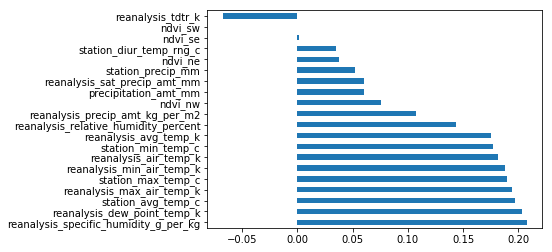

In [23]:
# compute the correlations
iq_features_with_lables = train_features[train_features['city'] == 'iq']
iq_features_with_lables['total_cases'] = train_labels_iq
iq_features_with_lables['residuals'] = iq_residuals_all
iq_correlations = iq_features_with_lables.corr()
# With total cases
(sj_correlations
     .total_cases
     .drop('total_cases')
     .drop('year')
     .drop('weekofyear') 
     .drop('residuals') 
     .sort_values(ascending=False)
     .plot
     .barh())


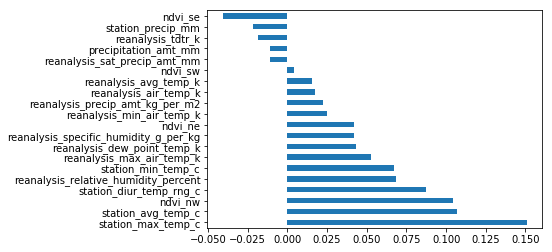

In [24]:

# With residuals
(sj_correlations
     .residuals
     .drop('total_cases')
     .drop('year')
     .drop('weekofyear') 
     .drop('residuals') 
     .sort_values(ascending=False)
     .plot
     .barh())


In [0]:
x_train_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[60:520]
x_train_means2= df_iq['reanalysis_relative_humidity_percent'].rolling(window = 52).mean()[60:520]
x_train_means3= df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 52).mean()[60:520]
x_train_means4= df_iq['reanalysis_dew_point_temp_k'].rolling(window = 52).mean()[60:520]
x_train_means5 =df_iq['reanalysis_min_air_temp_k'].rolling(window = 52).mean()[60:520]

In [0]:
x_train = pd.concat([x_train_means1,x_train_means2,x_train_means3,x_train_means4,x_train_means5], axis = 1)
y_train = iq_residuals_all[60:]

# For holdout validation
xx_train = pd.concat([x_train_means1[:338],x_train_means2[:338],x_train_means3[:338]], axis = 1)
yy_train = iq_residuals_all_holdout[60:]
xx_valid = pd.concat([x_train_means1[338:],x_train_means2[338:],x_train_means3[338:]], axis = 1)

In [0]:
x_test_means1 = df_iq['station_avg_temp_c'].rolling(window = 52).mean()[520:]
x_test_means2 = df_iq['reanalysis_relative_humidity_percent'].rolling(window = 52).mean()[520:]
x_test_means3 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 52).mean()[520:]
x_test_means4 = df_iq['reanalysis_dew_point_temp_k'].rolling(window = 52).mean()[520:]
x_test_means5 = df_iq['reanalysis_min_air_temp_k'].rolling(window = 52).mean()[520:]

In [0]:
x_test = pd.concat([x_test_means1,x_test_means2,x_test_means3,x_test_means4,x_test_means5], axis = 1)

In [29]:
iq_residual_lr = linear_model.Lasso()
iq_residual_lr.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
iq_monthly_prediction = pd.Series(iq_month_lr.predict(x_test_months)).rolling(8, min_periods=1).mean()
print(iq_monthly_prediction.size)
iq_resid_prediction = iq_residual_lr.predict(x_test)
print(iq_resid_prediction.size)
iq_cases_predictions = pd.Series(iq_resid_prediction + iq_monthly_prediction)
iq_cases_predictions = iq_cases_predictions.apply(lambda x: 0 if x < 1 else int(x))

156
156


Holdout validation

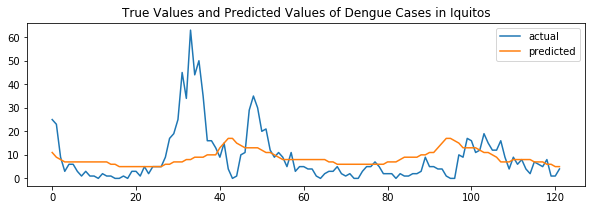

6.860655737704918


In [31]:
iq_residual_lr_holdout = linear_model.Lasso()
iq_residual_lr_holdout.fit(xx_train, yy_train)

iq_monthly_prediction_holdout = pd.Series(iq_month_lr_holdout.predict(xx_valid_months)).rolling(3, min_periods=1).mean()
iq_resid_prediction_holdout = iq_residual_lr_holdout.predict(xx_valid)
iq_cases_predictions_holdout = pd.Series(iq_resid_prediction_holdout + iq_monthly_prediction_holdout).rolling(1, min_periods=1).mean()
iq_cases_predictions_holdout = iq_cases_predictions_holdout.apply(lambda x: 0 if x < 1 else int(x))

# Plot
plt.figure(figsize=(10, 3))
plt.title('True Values and Predicted Values of Dengue Cases in Iquitos')
plt.plot(yy_valid, label = 'actual')
plt.plot(iq_cases_predictions_holdout, label = 'predicted')
plt.legend()
plt.show()

print mean_absolute_error(iq_cases_predictions_holdout, yy_valid)

Plot Monthly trend, Residuals, and True values

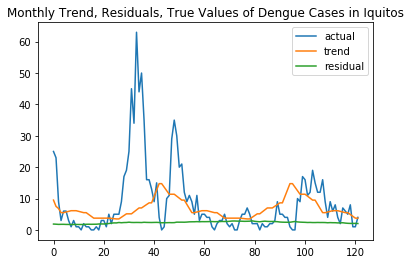

In [32]:
# Plot
plt.title('Monthly Trend, Residuals, True Values of Dengue Cases in Iquitos')
plt.plot(yy_valid, label = 'actual')
plt.plot(iq_monthly_prediction_holdout, label = 'trend')
plt.plot(iq_resid_prediction_holdout, label = 'residual')
plt.legend()
plt.show()

In [0]:
total_predictions = list(sj_cases_predictions) + list(iq_cases_predictions)

In [34]:
submission = pd.read_csv("https://s3.amazonaws.com/drivendata/data/44/public/submission_format.csv",index_col=[0, 1, 2])

submission['total_cases'] = total_predictions 
submission['total_cases'] = submission['total_cases'].apply(lambda x: int(x))
# submission_format.to_csv("./datasets/submission.csv",index=False)
print(submission)
submission.to_csv("attempt1.csv")
from google.colab import files

#files.download('attempt1.csv')

                      total_cases
city year weekofyear             
sj   2008 18                    1
          19                    1
          20                    1
          21                    1
          22                    1
          23                    1
          24                    1
          25                    1
          26                    1
          27                    1
          28                    3
          29                    8
          30                    8
          31                    9
          32                   15
          33                   23
          34                   30
          35                   31
          36                   34
          37                   37
          38                   40
          39                   37
          40                   37
          41                   42
          42                   46
          43                   51
          44                   55
          45  